## by Melek Derman 
## June 2025

## Ref: https://github.com/BrianOtieno/quantum-computing/blob/bd8e3497710d5d3c0841840e6867957ee19445d1/0015-quantum-walks.ipynb
## Ref 2: https://johnwatrous.com/wp-content/uploads/2023/08/AbsorbingQuantumWalks.pdf

## ❗️Develop, and if possible test and evaluate, an algorithm that solves the one-group, steady-state, slab geometry, isotropic scattering, isotropic fixed source transport equation using a Monte Carlo approach.


In [2]:
# Import necessary libraries
import numpy as np

from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit_aer import AerSimulator, Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

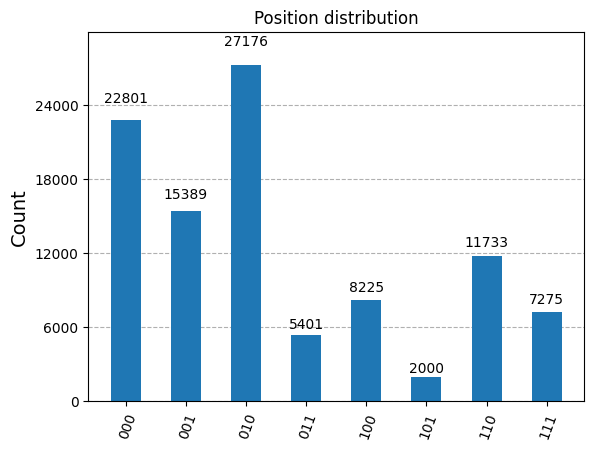

In [ ]:
def qw_circuit(n_qubits,n_steps, p_abs):

    N_qubits = n_qubits + 1 + 1 # eg. 3 position qubits + 1 ancilla qubit + 1 coin qubit
    qc = QuantumCircuit(N_qubits, N_qubits)   #N_qubits quantum, N_qubits classical bits

    # Uniform fixed source, W-state initialization
    dim = 2**n_qubits
    state = np.zeros(dim)
    for i in range(n_qubits):
        state[2**i] = 1/np.sqrt(n_qubits)

    # initialize the system qubits (ancilla qubit is left in |0>)
    qc.initialize(state, list(range(n_qubits)))

    # Coin operator for isotropic scattering
    coin = QuantumCircuit(1)
    coin.h(0)

    # Shift operator definitions for direction
    shift_r = QuantumCircuit(n_qubits)
    shift_l = QuantumCircuit(n_qubits)
    for i in range(n_qubits - 1):
        shift_r.cx(i, i + 1)
        shift_l.cx(i + 1, i)

    # coin + shift + absorption for every step
    #sin²(theta) = p_abs -- > Theta is applying a controlled-Ry(2 theta) gate, which makes the ancilla qubit transition to |1> with probability p_abs.

    theta = np.arcsin(np.sqrt(p_abs))
    ancilla_idx = n_qubits #last qubit is the ancilla

    for _ in range(n_steps):
        # coin operation on all system qubits
        for q in range(n_qubits):
            qc.append(coin, [q])

        # walk to the right and then to the left
        qc.append(shift_r, range(n_qubits))
        qc.append(shift_l, range(n_qubits))

        # unitary for absorption operation
        # If the ancilla is |1>, the system qubit is rotated with Ry(2*theta)
        for q in range(n_qubits):
            qc.cry(2*theta, q, ancilla_idx)  # controlled-Ry for absorption

    qc.measure(ancilla_idx, ancilla_idx)
    qc.measure(list(range(n_qubits)), list(range(n_qubits)))

    return qc
    

def simulation_and_postprocessing(qc: QuantumCircuit, shots: int, L: int):
    # AerSimulator

    backend   = AerSimulator()

    #Transpile the circuit for the backend
    transpiled = transpile(qc, backend)

    # Execute the circuit and get results
    result    = backend.run(transpiled, shots=shots).result()
    counts    = result.get_counts()

    pos_counts = {}
    for bitstr, cnt in counts.items():

        pos = bitstr[-n_qubits:][::-1]
        pos_counts[pos] = pos_counts.get(pos, 0) + cnt

    return plot_histogram(pos_counts,
                          title="Position distribution")


N           = 8
steps       = 100
xs_t        = 1.0
xs_s        = 0.5
p_abs       = (xs_t - xs_s) / xs_t
L           = 10.0
n_qubits    = int(np.log2(N))
shots       = 100000

qc = qw_circuit(n_qubits, steps, p_abs)

simulation_and_postprocessing(qc, shots, L)


